### A notebook to support academic question exploration and literature search / what do you do when you search the literature?

0. Define a research question e.g Is occupational **asbestos exposure** an underecognised **cause** of IPF? 
1. Consider the different possible ways of answering the question (methods). Different study designs and ways of measuring asbestos exposure e.g Epidemiological, observational, cross-sectional, cohort, case-control, post-mortem and explant studies, ecological, toxicology, animal models, molecular disease models, exposure assessment, occupational hygeinst measurements, minerologic analysis (tissue, BAL etc)
2. Generate search terms e.g "IPF", "case-control", "occupational", "asbestos" (? && mesh terms)
3. Carry out search using search terms and e.g pubmed, embase, google scholar, scopus, biorxiv, web of science, clinicaltrials.gov, ?google books, prepubmed.org
4. Search results == Candidate Papers
5. Extract title | journal | author | location | year | abstract | key words | full text && save result (as .bib) (prob want to export to jabref) https://stackoverflow.com/questions/30768745/is-there-a-reliable-python-library-for-taking-a-bibtex-entry-and-outputting-it-i
6. Review Candidate Papers to identify Relevant Papers 
7. Use Relevant Papers to identify more Candidate papers. Search also by author, cited by, cite, [triangle closing](https://en.wikipedia.org/wiki/Triadic_closure) e.g https://github.com/hinnefe2/bibcheck.py and other means (?tensorflow/scikit-learn,nltk), https://en.wikipedia.org/wiki/Jaccard_index, networkx?
8. Use the Relevant Papers collected for whatever it is they are relevant for (usually to help compose a written document in which they are cited). Including exporting to a nice table for LaTeX.
9. ?django app times

general discussion of the problem: 1. http://drugmonkey.scientopia.org/2010/09/28/on-keeping-abreast-of-the-literature-a-highly-loaded-poll-question/ 2. http://www.sciencemag.org/careers/2016/11/how-keep-scientific-literature

meta: github/stack exchange etc to check out other peoples search strategies. this is likely to be formulated as a machine learning problem somewhere.

#### interesting related I found includes: https://www.projectcredo.com/, http://citationexplorer.hoppmann.me/, http://cbdm-01.zdv.uni-mainz.de/~jfontain/cms/, lict from a previous nhshackday, https://github.com/jvoytek/pubmedbrain/blob/f5170a2e3540e0c2aa665559c86048dfb1583f16/documents/Voytek-brainSCANrPreprint.pdf, https://github.com/graeham/hackathon/blob/master/paperGraph.py

### search github for relevant stuff with the following 'webbit' 
> https://github.com/search?l=Python&q=http%3A%2F%2Feutils.ncbi.nlm.nih.gov%2Fentrez%2Feutils%2Fesearch.fcgi++stars%3A%3E5&ref=advsearch&type=Code&utf8=%E2%9C%93

gists and interwebs inc stackoverflow also helpful

tempting to dive into django a la https://github.com/afouchet/OpenReview but probably not essential and now is not optimal timing

https://github.com/gui11aume looks well documented, poss useful template
https://github.com/swcarpentry/2013-08-23-harvard/blob/b2097bc20833e0a58b2e73eecd1227d61bd5a00a/lessons/misc-biopython/eutils.md looks like nice intro to biopython utils and https://gist.github.com/bonzanini/5a4c39e4c02502a8451d, https://gist.github.com/ehazlett/1104507, https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 (for use of icite), https://gist.github.com/mcfrank/c1ec74df1427278cbe53, http://stackoverflow.com/questions/17409107/obtaining-data-from-pubmed-using-python, https://github.com/bwallace/abstrackr-web/tree/master/abstrackr, http://www.billconnelly.net/?p=44

### let's tackle pubmed first

In [1]:
"""
Notebook to support academic question exploration and literature search.

Thanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and 
http://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets
https://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 

Pubmed advanced search is helpful for designing search/experimenting 
https://www.ncbi.nlm.nih.gov/pubmed/advanced

Docs for NCBI esearch:
https://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch
https://www.nlm.nih.gov/bsd/mms/medlineelements.html
"""


'\nNotebook to support academic question exploration and literature search.\n\nThanks to https://marcobonzanini.wordpress.com/2015/01/12/searching-pubmed-with-python/ and \nhttp://www.fredtrotter.com/2014/11/14/hacking-on-the-pubmed-api/ and vtrubets\nhttps://gist.github.com/vtrubets/ef1dabb397ea6a05ce5b4e767ed15af9 \n\nPubmed advanced search is helpful for designing search/experimenting \nhttps://www.ncbi.nlm.nih.gov/pubmed/advanced\n\nDocs for NCBI esearch:\nhttps://www.ncbi.nlm.nih.gov/books/NBK25499/#chapter4.ESearch\nhttps://www.nlm.nih.gov/bsd/mms/medlineelements.html\n'

In [2]:
from Bio import Entrez
from Bio import Medline
from tqdm import tqdm
from collections import Counter, OrderedDict
import json
import requests
import re
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
%matplotlib inline

In [3]:
def get_chunked_pmids(term, chunksize=50):
    """
    Return a list of Pubmed ids from pubmed search in chunks
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    count_handle = Entrez.esearch(db="pubmed",
                                  term=term,
                                  retmode="xml",
                                  rettype="count")
    count_results = Entrez.read(count_handle)
    count = int(count_results["Count"])

    retmax_requests = list(range(chunksize, count, chunksize))
    retmax_requests.append(count - retmax_requests[len(retmax_requests) - 1])

    for i, retmax in enumerate(retmax_requests):
        pmid_handle = Entrez.esearch(db="pubmed",
                                     term=term,
                                     sort="relevance",
                                     retmode="xml",
                                     usehistory='y',
                                     retstart=retmax,
                                     retmax=chunksize)
        results = Entrez.read(pmid_handle)
        yield results["IdList"]

In [4]:
def get_pubmed_summaries(pubmed_id):
    """
    Use the Pubmed API to return a json summary of a list of pmid strings 
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string

    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.esummary(db='pubmed', 
                             id=pubmed_id, 
                             retmode='json',
                             rettype='abstract')
    return json.loads(handle.read())['result']
  

In [5]:
def get_pubmed_keywords(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the key words for each pmid in a
    a list of pmid strings. Returns {pmid:[list of keywords]}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    keywords = {}
    for record in records:
        pmid = record.get('PMID','?')
        mh = record.get('MH','?')
        keywords[pmid] = mh
    return keywords

In [6]:
def get_pubmed_abstracts(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the abstract for each pmid in a list
    of pmid strings. Return {pmid:abstract}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    abstracts = {}
    for record in records:
        pmid = record.get('PMID','?')
        ab = record.get('AB','?')
        abstracts[pmid] = ab
    return abstracts

In [7]:
def get_pubmed_pubtypes(pubmed_id):
    """
    Use the Pubmed API to return the medline record and extract the publication type for each pmid
    in a list of pmid strings. Return {pmid:pubtype}.
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.efetch(db='pubmed',
                           id=pubmed_id,
                           rettype='medline',
                           retmode='text')
    records = Medline.parse(handle)
    pubtypes = {}
    for record in records:
        pmid = record.get('PMID','?')
        pt = record.get('PT','?')
        pubtypes[pmid] = pt
    return pubtypes

In [8]:
def get_citation_information(pubmed_id):
    """
    Use the special citation api to return relative citation ratios
    Takes a list of pmid strings. Returns {pmid:rcr}
    (what rcr is http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1002541)
    """
    pubmed_id = ','.join(pubmed_id) # citation api likes to take a single string
    citation_search = 'https://icite.od.nih.gov/api/pubs?pmids={0}'.format(pubmed_id)
    response = requests.get(citation_search).content
    str_response = response.decode('utf-8')
    
    try:
        data = json.loads(str_response)['data']
    except KeyError:
        data = False
         
    citations = {}
    
    if data:
        for record in data:
            pmid = record.get('pmid')
            rcr = record.get('relative_citation_ratio')
            citations[pmid] = rcr
    return citations
        

In [9]:
def get_pmids_for_papers_citing(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a *single pmid*
    Return list of citing pmids.
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_citedin")
    records = Entrez.read(handle)
    list_of_pmids_citing = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_citing.append(link["Id"]) 
  
    return list_of_pmids_citing 

In [10]:
def get_pmids_for_papers_cited(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for papers cited by a particular pmid
    Return list of pmids. *only works for papers in pubmed central*
    see also https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
    """
    Entrez.email = "carl.reynolds@imperial.ac.uk"
    handle = Entrez.elink(dbfrom="pubmed",
                          id=pubmed_id,
                          linkname="pubmed_pubmed_refs")
    records = Entrez.read(handle)
    list_of_pmids_cited = []
    
    if records[0]["LinkSetDb"]:
        for link in records[0]["LinkSetDb"][0]["Link"]:
            list_of_pmids_cited.append(link["Id"]) 
    return list_of_pmids_cited

In [11]:
def get_cited_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper cited by pmid
    in a list of pmids. Return {pmid:list_of_citing_pmids}
    Only works for papers in PMC
    """
    cited = {}
    for pmid in pubmed_id:
        cited[pmid] = get_pmids_for_papers_cited(pmid)
    return cited

In [12]:
def get_citing_pmids(pubmed_id):
    """
    Use the Pubmed API to return a list of pmids for a paper citing a pmid
    in a list of pmids
    Return {pmid:list_of_citing_pmids}
    """
    citing = {}
    for pmid in pubmed_id:
        citing[pmid] = get_pmids_for_papers_citing(pmid)
  
    return citing

In [13]:
def lit_fetch(pubmed_id):
    """
    Search pubmed for a list of pmid strings and return information about the results
    """
    result = {}
    result['summaries'] = get_pubmed_summaries(pubmed_id)
    result['pubtypes'] = get_pubmed_pubtypes(pubmed_id)
    result['abstracts'] = get_pubmed_abstracts(pubmed_id)
    result['keywords'] = get_pubmed_keywords(pubmed_id)
    result['rcrs'] = get_citation_information(pubmed_id)
    result['citing'] = get_citing_pmids(pubmed_id)
    result['cited'] = get_cited_pmids(pubmed_id)
    return result
        

In [14]:
def resultdf(r):
    df = pd.DataFrame(r['summaries']['uids'], columns=['pmid'])
    df['title'] = df['pmid'].map(lambda x: r['summaries'].get(x)['title'])
    df['firstauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortfirstauthor'])
    df['lastauthor'] = df['pmid'].map(lambda x: r['summaries'].get(x)['lastauthor'])
    df['journal'] = df['pmid'].map(lambda x: r['summaries'].get(x)['source'])
    df['pubdate'] = df['pmid'].map(lambda x: r['summaries'].get(x)['sortpubdate'])
    df['pubtype'] = df['pmid'].map(lambda x: r['pubtypes'].get(x))
    df['abstract'] = df['pmid'].map(lambda x: r['abstracts'].get(x))
    df['keywords'] = df['pmid'].map(lambda x: r['keywords'].get(x))
    df['rcr'] = df['pmid'].astype(int).map(lambda x: r['rcrs'].get(x))
    df['citedby'] =  df['pmid'].map(lambda x: r['citing'].get(x))
    df['cites'] = df['pmid'].map(lambda x: r['cited'].get(x))
    pd.set_option('max_colwidth',300)
    return df

In [15]:
def save_df_as_csv(term, df):
    name = term.replace(" ", "-")
    df.to_csv(name+".csv")

In [16]:
def lit_search(term):
    """
    Search pubmed for a term and collect information about the results
    """
    pmid_blocks = get_chunked_pmids(term, chunksize=200)
    df_list = []
    for i, block in enumerate(pmid_blocks):
        if i < 1:
            print("Beginning block processing")
            result = lit_fetch(block)
            df = resultdf(result)
            df_list.append(df)
            print("Processed block {0}".format(i))
    df = pd.concat(df_list)
    save_df_as_csv(term, df)
    return df
        

In [17]:
def explore_result_dataframe(df):
    """
    Print some simple stats for result dataframe
    """
    print('Top first authors\n')
    print(df.firstauthor.value_counts().head())
    print('\nTop last authors\n')
    print(df.lastauthor.value_counts().head())
    print('\nTop journals\n')
    print(df.journal.value_counts().head())
    print('\nTop publication types\n')
    print(df.pubtype.astype(str).value_counts().head())
    print('\nPublications per year\n')
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate
    df.groupby(df.pubdate.map(lambda x: x.year)).pmid.count().plot(kind='bar')


In [18]:
def jaccard(s1, s2):
    " takes two lists as input and returns Jaccard coefficient"
    st1=set(s1)
    st2=set(s2)
    u = set(st1).union(st2)
    i = set(st1).intersection(st2)
    return len(i)/len(u)

Top first authors

Raghu G        44
Cottin V       42
Behr J         27
Selman M       27
Antoniou KM    24
Name: firstauthor, dtype: int64

Top last authors

Collard HR    46
Wells AU      43
Bouros D      42
Raghu G       41
Crystal RG    39
Name: lastauthor, dtype: int64

Top journals

Am J Respir Crit Care Med    397
Chest                        273
Eur Respir J                 268
Respir Med                   158
Thorax                       144
Name: journal, dtype: int64

Top publication types

['Journal Article']                                        1813
['Journal Article', "Research Support, Non-U.S. Gov't"]     929
['Journal Article', 'Review']                               729
['Case Reports', 'Journal Article']                         331
['English Abstract', 'Journal Article']                     251
Name: pubtype, dtype: int64

Publications per year



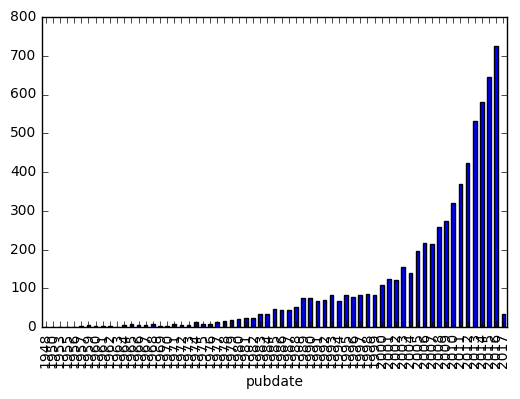

In [19]:
# df = lit_search('idiopathic pulmonary fibrosis')
df = pd.read_csv('idiopathic-pulmonary-fibrosis.csv')
explore_result_dataframe(df)

In [20]:
pmid_blocks = get_chunked_pmids('idiopathic pulmonary fibrosis', chunksize=200)


In [21]:
terms = ['idiopathic pulmonary fibrosis', 'cryptogenic fibrosing alveolitis',
        'usual interstitial pneumonia', 'asbestosis']

#?(idiopathic pulmonary fibrosis) AND (asbestos) 

def litsearch_terms(terms):
    """
    Search pubmed for the terms and return a df
    """
    df_list = []
    for term in terms:
        print ('searching for {0}'.format(term))
        df = lit_search(term)
        df_list.append(df)
        save_df_as_csv(term, df)
    df = pd.concat(df_list)
    return df

In [22]:
topic_collection = {"ipfjes_case_control_studies" : ['23022860', '10968375', '24413348', '19782552', '17628464', 
                                                     '10841131', '8569361', '8087336', '15640309', '9571528', 
                                                     '18507288', '23022860', '2249047'], 
                    "ipfjes_reviews" : ['25621562', '24348069', '10193340', '11816818', '15331187', '16733403']}


def litfetch_topics(topic_collection):
    """
    fetch info for pmids in a topic collection and save the result as a .csv
    """
    for topic in topic_collection:
        print('begining topic {0} analaysis'.format(topic))
        result = lit_fetch(topic_collection[topic])
        df = resultdf(result)
        save_df_as_csv(topic, df)
        print('csv of topic {0} saved'.format(topic))

In [23]:
def citing_count(pubmed_id):
    '''
    Looks up papers citing a list of pubmed_id strings and returns a dict
    {citing_paper:number_of_times_cites_list}
    '''
    citing = get_citing_pmids(pubmed_id)
    corpus = []
    for record in citing:
        corpus.append(citing[record])
    corpus = [item for sublist in corpus for item in sublist]
    x = Counter(corpus)
    citingpapers = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
    citing_count = dict(citingpapers)
    return citing_count

In [24]:
def jaccard_table(df):
    df1 = df[df.cites != '[]'] 
    # make a dataframe of papers that 
    # we have citation info for (ones in pmc)
    
    # eval to get list out of string
    # lets just work with this
    df2 = df1[['pmid', 'citedby']]
    
    # make the string of a list a list
    df2.citedby = df2.citedby.map(eval)
    
    # make a tidy dataframe
    df3 = pd.concat([df2.drop(['citedby'], axis=1), df2.citedby.apply(pd.Series)], axis=1)
    df4 = pd.melt(df3, id_vars='pmid')
    df4.drop('variable', axis=1, inplace=True)
    df4.columns = ['pmid', 'citedby']
    
    # adds a 'whichcites' column
    df4['whichcites'] = df4['citedby'].map(lambda x: get_cited_pmids([x]).values())
    
    # makes our which cites dict_lists single list lists
    df4.whichcites = df4.whichcites.map(list)
    df4.whichcites = df4.whichcites.map(lambda x: x.pop())
    
    # add cites column back in
    df5 = pd.merge(df1[['pmid', 'cites']], df4, on='pmid')
    
    # make list string a list
    df5.cites = df5.cites.map(eval)
    
    # make pmid values be str
    df5.pmid = df5.pmid.astype(str)
    
    # make citedby values be str
    df5.citedby = df5.citedby.astype(str)
    
    # add jaccard column
    df5['jaccard'] = 0
    for i in range(len(df5)):
        df5['jaccard'].iloc[i] = jaccard(df5.cites.iloc[i], df5.whichcites.iloc[i])
        
    return df5
    

In [25]:
def jaccard_tabledf(jaccard_table):
    df = jaccard_table.sort_values(by='jaccard', ascending=False)
    df = df[df['citedby'] != 'nan']
    r = lit_fetch(list(df.pmid.unique()))
    df['seed paper'] = df['pmid'].map(lambda x: r['summaries'].get(x)['title'])
    
    r = lit_fetch(list(df.citedby))
    df['title'] = df['citedby'].map(lambda x: r['summaries'].get(x)['title'])
    df['firstauthor'] = df['citedby'].map(lambda x: r['summaries'].get(x)['sortfirstauthor'])
    df['lastauthor'] = df['citedby'].map(lambda x: r['summaries'].get(x)['lastauthor'])
    df['journal'] = df['citedby'].map(lambda x: r['summaries'].get(x)['source'])
    df['pubdate'] = df['citedby'].map(lambda x: r['summaries'].get(x)['sortpubdate'])
    df['pubtype'] = df['citedby'].map(lambda x: r['pubtypes'].get(x))
    df['keywords'] = df['citedby'].map(lambda x: r['keywords'].get(x))
    df['rcr'] = df['citedby'].astype(int).map(lambda x: r['rcrs'].get(x))
    
    return df[['citedby', 'title', 'firstauthor', 'lastauthor', 'journal', 
              'pubdate', 'pubtype', 'rcr', 'jaccard']]

In [26]:
df = pd.read_csv('ipfjes_case_control_studies.csv', usecols=['pmid','title','firstauthor','lastauthor',
                                                             'journal','pubdate','pubtype',
                                                             'abstract', 'keywords', 'rcr', 'citedby', 'cites'])


In [27]:
keywords = get_pubmed_keywords(topic_collection['ipfjes_case_control_studies'])

print ('Top pubmed keywords (mesh headings)',
       'for the {0} occupational IPF case-control studies found'.format(len(keywords)))

corpus = []
       
for record in keywords:
    corpus.append(keywords[record])
    
corpus = [item for sublist in corpus for item in sublist]

x = Counter(corpus)

top_keywords = [(l,k) for k,l in sorted([(j,i) for i,j in x.items()], reverse=True)]
top_keywords[:5]

Top pubmed keywords (mesh headings) for the 12 occupational IPF case-control studies found


[('Male', 12),
 ('Humans', 12),
 ('Female', 12),
 ('Case-Control Studies', 10),
 ('Aged', 8)]

In [32]:
def citingpaperdf():
    citing_count = citing_count(topic_collection['ipfjes_case_control_studies'])
    result = lit_fetch(list(citing_count.keys()))
    df = resultdf(result)
    df.pubdate = pd.to_datetime(df.pubdate)
    df.index = df.pubdate.map(lambda x: x.year)
    df = df.sort_values(by = 'pubdate', ascending=True)
    df['citations of pmidgrp'] = df.pmid.map(lambda x: citing_count.get(x))
    df = df[['title','firstauthor', 'lastauthor', 'journal', 'pubtype', 'rcr', 'citations of pmidgrp']]
    df.to_csv('papers_citing_ipf_occupational_dust_case_control_studies.csv')
    return df

In [47]:
# citingpaperdf()

IPF case-control studies and their citing papers (node size scaled to relative citation ratio)

Key : pubmed id : title author year : (n of citations)
0 : 8569361 : Occupational exposure to metal or wood dust and aetiology of cryptogenic fibrosing alveolitis. Hubbard R 1996 (40)
1 : 10968375 : Occupational and environmental risk factors for idiopathic pulmonary fibrosis: a multicenter case-control study. Collaborating Centers. Baumgartner KB 2000 (39)
2 : 8087336 : Idiopathic pulmonary fibrosis. Epidemiologic approaches to occupational exposure. Iwai K 1994 (30)
3 : 2249047 : What causes cryptogenic fibrosing alveolitis? A case-control study of environmental exposure to dust. Scott J 1990 (24)
4 : 15640309 : Occupational and environmental factors and idiopathic pulmonary fibrosis in Japan. Miyake Y 2005 (11)
5 : 19782552 : Risk factors for idiopathic pulmonary fibrosis in a Mexican population. A case-control study. García-Sancho Figueroa MC 2010 (9)
6 : 10841131 : Risk of cryptogenic f

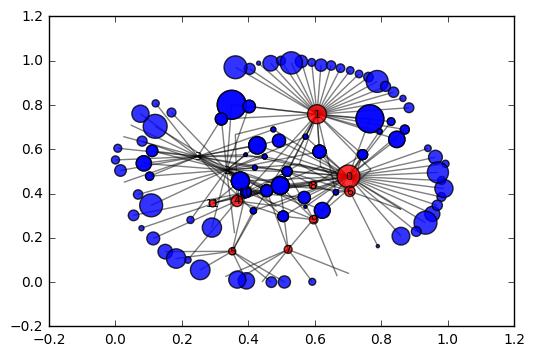

In [40]:
# G = nx.DiGraph(nx.from_dict_of_lists(citing))
citing = get_citing_pmids(topic_collection['ipfjes_case_control_studies'])

citing = OrderedDict(sorted(citing.items(), key=lambda t: len(t[1])))

citing = OrderedDict(reversed(list(citing.items())))

G = nx.from_dict_of_lists(citing)

pos=nx.spring_layout(G)

l = list(citing.keys())
r = get_citation_information(l)
rcrs = [r.get(int(e)) for e in l]
ns1 = [0 if v is None else v for v in rcrs]

    
nx.draw_networkx_nodes(G,pos,
                       nodelist=citing.keys(),
                       node_color='r',
                       node_size=[i * 50 for i in ns1],
                       alpha=0.8)

l = [item for sublist in citing.values() for item in sublist]
r = get_citation_information(l)
rcrs = [r.get(int(e)) for e in l]
ns2 = [0 if v is None else v for v in rcrs]


nx.draw_networkx_nodes(G,pos,
                       nodelist=[item for sublist in citing.values() for item in sublist],
                       node_color='b',
                       node_size=[i * 50 for i in ns2],
                       alpha=0.8)

nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels = {}

for i, item in enumerate(citing):
    labels[item] = i
    
nx.draw_networkx_labels(G,pos,labels,font_size=8)

print ('IPF case-control studies and their citing papers (node size scaled to relative citation ratio)\n')
    
    
print ('Key : pubmed id : title author year : (n of citations)')

for i, item in enumerate(citing):
    print(i,':', item, ':', get_pubmed_summaries([item])[item]['title'],
          get_pubmed_summaries([item])[item]['sortfirstauthor'], 
          get_pubmed_summaries([item])[item]['sortpubdate'][:4],
          '({0})'.format(len(citing[item])))
    
plt.savefig('PapersThatIPFCaseControlStudies.svg')

In [48]:
# papers citing seed papers by coverage
df = pd.read_csv('papers_citing_ipf_occupational_dust_case_control_studies.csv')
df.sort_values(by='citations of pmidgrp', ascending=False)

,pubdate,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
63,2013,Epidemiology of idiopathic pulmonary fibrosis.,Ley B,Collard HR,Clin Epidemiol,"['Journal Article', 'Review']",3.114474,10
43,2011,New insights into the pathogenesis and treatment of idiopathic pulmonary fibrosis.,Ding Q,Thannickal VJ,Drugs,"['Journal Article', 'Research Support, N.I.H., Extramural', ""Research Support, Non-U.S. Gov't"", 'Review']",1.379412,9
65,2014,"Effects of smoking, gender and occupational exposure on the risk of severe pulmonary fibrosis: a population-based case-control study.",Ekström M,Torén K,BMJ Open,"['Journal Article', ""Research Support, Non-U.S. Gov't""]",1.144405,8
81,2015,Asbestosis and environmental causes of usual interstitial pneumonia.,Gulati M,Redlich CA,Curr Opin Pulm Med,"['Journal Article', 'Review']",0.943542,8
38,2009,Cigarette smoking is associated with subclinical parenchymal lung disease: the Multi-Ethnic Study of Atherosclerosis (MESA)-lung study.,Lederer DJ,Barr RG,Am J Respir Crit Care Med,"['Journal Article', 'Research Support, N.I.H., Extramural', ""Research Support, Non-U.S. Gov't""]",3.310302,5
99,2016,Idiopathic Pulmonary Fibrosis: A Genetic Disease That Involves Mucociliary Dysfunction of the Peripheral Airways.,Evans CM,Schwartz DA,Physiol Rev,"['Journal Article', 'Review']",NaN,5
98,2016,Genome-wide imputation study identifies novel HLA locus for pulmonary fibrosis and potential role for auto-immunity in fibrotic idiopathic interstitial pneumonia.,Fingerlin TE,Schwartz DA,BMC Genet,['Journal Article'],NaN,4
24,2004,The epidemiology of interstitial lung disease and its association with lung cancer.,Raghu G,Morgan G,Br J Cancer,"['Journal Article', 'Review']",1.747284,4
70,2014,Idiopathic pulmonary fibrosis: early detection and referral.,Oldham JM,Noth I,Respir Med,"['Journal Article', ""Research Support, Non-U.S. Gov't"", 'Review']",1.139613,4
56,2012,Newly recognized occupational and environmental causes of chronic terminal airways and parenchymal lung disease.,Sauler M,Gulati M,Clin Chest Med,"['Journal Article', 'Review']",1.008971,4


In [49]:
# papers citing seed papers by rcr
df = pd.read_csv('papers_citing_ipf_occupational_dust_case_control_studies.csv')
df.sort_values('rcr', ascending=False)

,pubdate,title,firstauthor,lastauthor,journal,pubtype,rcr,citations of pmidgrp
35,2009,"Pulmonary fibrosis: pathogenesis, etiology and regulation.",Wilson MS,Wynn TA,Mucosal Immunol,"['Journal Article', 'Research Support, N.I.H., Intramural', 'Review']",8.678789,2
29,2006,Incidence and mortality of idiopathic pulmonary fibrosis and sarcoidosis in the UK.,Gribbin J,Tata LJ,Thorax,"['Journal Article', ""Research Support, Non-U.S. Gov't""]",8.027668,2
27,2006,Classification and natural history of the idiopathic interstitial pneumonias.,Kim DS,King TE Jr,Proc Am Thorac Soc,"['Journal Article', 'Research Support, N.I.H., Extramural', 'Review']",5.930767,1
59,2013,MUC5B promoter polymorphism and interstitial lung abnormalities.,Hunninghake GM,Schwartz DA,N Engl J Med,"['Journal Article', 'Research Support, N.I.H., Extramural', ""Research Support, U.S. Gov't, Non-P.H.S.""]",5.447068,1
89,2015,"TOLLIP, MUC5B, and the Response to N-Acetylcysteine among Individuals with Idiopathic Pulmonary Fibrosis.",Oldham JM,Noth I,Am J Respir Crit Care Med,"['Journal Article', 'Research Support, N.I.H., Extramural', ""Research Support, Non-U.S. Gov't""]",5.441405,1
33,2008,Idiopathic pulmonary fibrosis.,Meltzer EB,Noble PW,Orphanet J Rare Dis,"['Journal Article', 'Review']",5.408593,1
19,2003,HLA-DRB1*1101: a significant risk factor for sarcoidosis in blacks and whites.,Rossman MD,Monos D,Am J Hum Genet,"['Journal Article', 'Multicenter Study', ""Research Support, U.S. Gov't, P.H.S.""]",5.168552,1
72,2014,Association of fine specificity and repertoire expansion of anticitrullinated peptide antibodies with rheumatoid arthritis associated interstitial lung disease.,Giles JT,Bathon JM,Ann Rheum Dis,"['Journal Article', 'Research Support, N.I.H., Extramural']",5.003475,1
4,1997,British Thoracic Society study of cryptogenic fibrosing alveolitis: current presentation and initial management. Fibrosing Alveolitis Subcommittee of the Research Committee of the British Thoracic Society.,Johnston ID,Rudd RM,Thorax,"['Journal Article', ""Research Support, Non-U.S. Gov't""]",4.620485,1
76,2015,Epigenetics of idiopathic pulmonary fibrosis.,Yang IV,Schwartz DA,Transl Res,"['Journal Article', 'Research Support, N.I.H., Extramural', ""Research Support, U.S. Gov't, Non-P.H.S."", 'Review']",3.962266,1


In [50]:
# papers citing seed papers (ipfjes case-control studies) by jaccard index
df = pd.read_csv('ipfjes_case_control_studies.csv')
jt = jaccard_table(df)
jdf = jaccard_tabledf(jt)
jdf

/home/drcjar/.virtualenvs/litsearch/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/drcjar/.virtualenvs/litsearch/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,citedby,title,firstauthor,lastauthor,journal,pubdate,pubtype,rcr,jaccard
1,25621562,Asbestosis and environmental causes of usual interstitial pneumonia.,Gulati M,Redlich CA,Curr Opin Pulm Med,2015/03/01 00:00,"[Journal Article, Review]",0.943542,0.134328
44,8882078,Mortality rates from cryptogenic fibrosing alveolitis in seven countries.,Hubbard R,Britton J,Thorax,1996/07/01 00:00,[Journal Article],2.405705,0.125000
38,11009575,"Review of cryptogenic fibrosing alveolitis, including current treatment guidelines.",Bourke SC,Clague H,Postgrad Med J,2000/10/01 00:00,"[Journal Article, Review]",0.110620,0.076923
0,26285574,Re-evaluation of diagnostic parameters is crucial for obtaining accurate data on idiopathic pulmonary fibrosis.,Kaunisto J,Myllärniemi M,BMC Pulm Med,2015/08/19 00:00,"[Journal Article, Multicenter Study, Research Support, Non-U.S. Gov't]",1.162714,0.071429
2,25121989,Mucin 5B promoter polymorphism is associated with susceptibility to interstitial lung diseases in Chinese males.,Wang C,Wang Y,PLoS One,2014/08/14 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",1.541612,0.063492
41,10943637,Interferon gamma-1b therapy for cryptogenic fibrosing alveolitis.,Britton J,Britton J,Thorax,2000/08/01 00:00,"[Journal Article, Review]",0.000000,0.041667
40,10992540,Adult height and cryptogenic fibrosing alveolitis: a case-control study using the UK general practice research database.,Hubbard R,Venn A,Thorax,2000/10/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",0.232555,0.037037
37,11083888,Capsaicin induced cough in cryptogenic fibrosing alveolitis.,Doherty MJ,Calverley PM,Thorax,2000/12/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",1.383640,0.032258
45,8553293,Epstein-Barr virus replication within pulmonary epithelial cells in cryptogenic fibrosing alveolitis.,Egan JJ,Woodcock AA,Thorax,1995/12/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",3.073204,0.026316
39,11006787,"The diagnosis, assessment and treatment of diffuse parenchymal lung disease in adults. Introduction.",,,Thorax,1999/04/01 00:00,"[Journal Article, Review]",0.529739,0.026201


In [51]:
# papers citing seed papers (ipfjes reviews) by jaccard index

df = pd.read_csv('ipfjes_reviews.csv')
jt = jaccard_table(df)
jdf = jaccard_tabledf(jt)
jdf

/home/drcjar/.virtualenvs/litsearch/lib/python3.5/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/drcjar/.virtualenvs/litsearch/lib/python3.5/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,citedby,title,firstauthor,lastauthor,journal,pubdate,pubtype,rcr,jaccard
29,26841042,Epidemiology of Idiopathic Pulmonary Fibrosis in Northern Italy.,Harari S,Cesana G,PLoS One,2016/02/03 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",NaN,0.144444
37,26400796,Incorporating genetics into the identification and treatment of Idiopathic Pulmonary Fibrosis.,Mathai SK,Schwartz DA,BMC Med,2015/09/24 00:00,[Journal Article],0.359310,0.136364
33,26595739,MUC5B and Idiopathic Pulmonary Fibrosis.,Yang IV,Schwartz DA,Ann Am Thorac Soc,2015/11/01 00:00,[Journal Article],0.146598,0.132812
41,25121989,Mucin 5B promoter polymorphism is associated with susceptibility to interstitial lung diseases in Chinese males.,Wang C,Wang Y,PLoS One,2014/08/14 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",1.541612,0.090909
36,26511746,UK asbestos imports and mortality due to idiopathic pulmonary fibrosis.,Barber CM,Fishwick D,Occup Med (Lond),2016/03/01 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",NaN,0.065217
31,26732054,Clinical and economic burden of idiopathic pulmonary fibrosis: a retrospective cohort study.,Raimundo K,Swigris JJ,BMC Pulm Med,2016/01/05 00:00,[Journal Article],NaN,0.063830
39,26176965,Epigenetics in lung fibrosis: from pathobiology to treatment perspective.,Helling BA,Yang IV,Curr Opin Pulm Med,2015/09/01 00:00,"[Journal Article, Research Support, N.I.H., Extramural, Review]",0.663899,0.051546
34,26594173,MicroRNAs as potential targets for progressive pulmonary fibrosis.,Rajasekaran S,Sudhakar Gandhi PS,Front Pharmacol,2015/11/05 00:00,"[Journal Article, Review]",2.368967,0.047368
26,27023440,Impact of Comorbidities on Mortality in Patients with Idiopathic Pulmonary Fibrosis.,Kreuter M,Herth FJ,PLoS One,2016/03/29 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",NaN,0.045045
32,26637194,The care needs of patients with idiopathic pulmonary fibrosis and their carers (CaNoPy): results of a qualitative study.,Sampson C,Byrne A,BMC Pulm Med,2015/12/04 00:00,"[Journal Article, Research Support, Non-U.S. Gov't]",0.752891,0.043011
